Cannot switch directories
800
8.0
750
-0.015


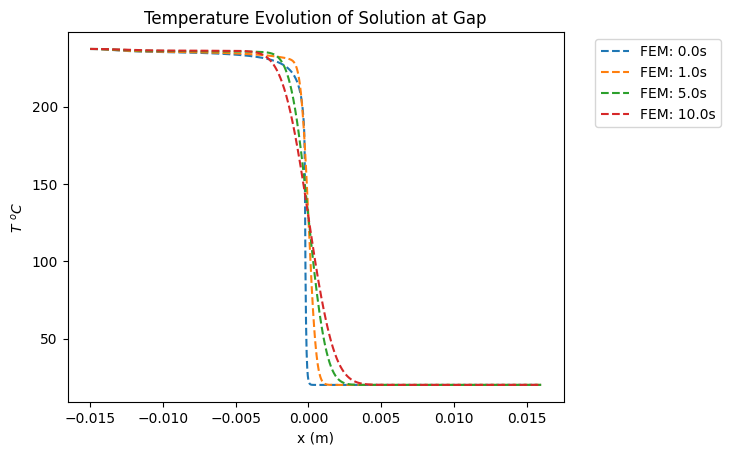

In [97]:
import os
import glob
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.animation as animation
import scipy.io as scio

from dolfin import *
from fenics import *
import warnings

# %%
# Geubelle research group
# Authors:  Qibang Liu (qibang@illinois.edu)
#           Michael Zakoworotny (mjz7@illinois.edu)
#           Philippe Geubelle (geubelle@illinois.edu)
#           Aditya Kumar (aditya.kumar@ce.gatech.edu)
#
# An example of running the FP solver for DCPD

import os
from solver_FP import FP_solver
from kinetics_library import Prout_Tompkins_Diffusion
from postProcess_FP import Post_process, saveResults, loadResults


# Sam's imports
from scipy import interpolate as itp
from scipy.integrate import quad
from scipy import optimize


# Switch to current directory
try:
    os.chdir(os.path.dirname(__file__))
except:
    print("Cannot switch directories")

# Thermo-chemical properties
kr = 0.15      # thermal conductivity, W/m-K
rhor = 980.0    # density, kg/m^3
Cpr = 1600.0    # specific heat, J/kg-K

# Nature values
Hr = 350000    # enthalpy, J/kg
A_ = 8.55e15    # pre-exponential constant, 1/s
Er = 110750.0   # activation energy J/mol
n = 1.72        # cure kinetics parameter
m = 0.77        # cure kinetics parameter
Ca = 14.48      # cure kinetics parameter
alpha_c = 0.41  # cure kinetics parameter

# Initial conditions for temperature and degree of cure
T0 = 20         # deg C
alpha0 = 0.01

# Length of domain
L = 0.03

# Run the solver until 10 s
t_end = 250
save_dir = "out_DCPD"  # path to save the result files.

# Pack the results for future use
#loadedResults = loadResults(save_dir, "data_DCPD")  # load from .mat file
#results_data = loadedResults

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx
    else:
        return idx

find_first = lambda a, val, tol: next(i for i, _ in enumerate(a) if np.isclose(_, val, tol))

# make a matrix where we can interate h -> gap,time then loop the h's and plot scatters

proc_data = {0:[],100:[],200:[],300:[],400:[],500:[],1000:[],5000:[]}

#for file in glob.iglob(save_dir + "/*.mat"):
#    name = file[9:-4]
#    gaplen,hval = file[14:-4].split("_")
#    if gaplen == "0.001" and hval == "0":        
#        break
#print(gaplen + hval)
#results_data = loadResults(save_dir, name)
#gaplen = str(float(gaplen) / 1e3)
#x = results_data['x_data'][0,:]
#zeroidx = find_nearest(x,0.0)
#if x[zeroidx] > 0:
#    zeroidx -= 1
#alpha=results_data['alpha_data'][:,zeroidx]
#t=results_data['t_data'][:,zeroidx]
#tidx=find_nearest(alpha,0.5)
#t_gs=t[tidx-1]
#T=results_data['T_data'][int(t_gs*100),:]
#x=results_data['x_data'][int(t_gs*100),:]
#plt.plot(x,T)

    
    
    
#    data_point = [float(gaplen), halftime]
#    proc_data[int(hval)].append(data_point)
#    minval = np.min(t)
#    print(minval)
#    plt.plot(t,alpha)

#results_data = loadResults(save_dir, name)
#x=results_data['x_data'][0,:]
#idx = find_nearest(x,0.003) 
#alpha=results_data['alpha_data'][:,idx]
#t=results_data['t_data'][:,idx]
#plt.plot(t,alpha)

#for file in glob.iglob(save_dir + "/*.mat"):
#    name = file[9:-4]
#    #results_data = loadResults(save_dir, name)
#    gaplen,hval = file[14:-4].split("_")
#    gaplen = str(float(gaplen) / 1e3)
#    #print("hval: " + hval + " gaplen: " + gaplen)
#    if hval == "0" and gaplen == "0.0005":
#        print("in the loop bruh")
#        print(hval)
#        print(gaplen)
#        x = results_data['x_data'][0,:]
#        idx = find_nearest(x,float(gaplen))
#        T=results_data['T_data'][:,idx]
#        t=results_data['t_data'][:,idx]
#        plt.plot(t,T)

#times = [0, 100, 500, 1000, 2000, 3000]
#for file in glob.iglob(save_dir + "/*.mat"):
#    name = file[9:-4]
#    gaplen,hval = file[14:-4].split("_")
#    gaplen = str(float(gaplen) / 1e3)
#    gaplen = "0.005"
#    hval = "0"
#    break
#results_data = loadResults(save_dir, name)
#for time in times:
#    T = results_data['T_data'][975+time,:]
#    theta = (T-np.min(T))/(np.max(T)-np.min(T))
#    x = results_data['x_data'][975+time,:]
#    plt.plot(x,theta,label=f"{time/100}s")
#plt.legend()

times = [0,100,500,1000]
for file in glob.iglob(save_dir + "/*.mat"):
    name = file[9:-4]
    gaplen,hval = file[14:-4].split("_")
    gaplen = str(float(gaplen) / 1e3)
    if gaplen == "0.001" and hval == "0":
        break
results_data = loadResults(save_dir, name)
x = results_data['x_data'][0,:]
zeroidx = find_nearest(x,0.0)
idx = find_nearest(x,float(gaplen))
print(idx)
print(t[idx])
print(zeroidx)
print(x[0])
alpha=results_data['alpha_data'][:,zeroidx]
T = results_data['T_data'][:,zeroidx] - 273
theta = (T-np.min(T))/(np.max(T)-np.min(T))
t = results_data['t_data'][:,zeroidx]
tidx = find_nearest(theta,0.02)
t_gs=t[int(tidx)]
for time in times:
    T = results_data['T_data'][int(t_gs*100)+time,:] - 273
    x = results_data['x_data'][int(t_gs*100)+time,:]
    plt.plot(x,T,'--',label=f"FEM: {time/100}s")
plt.legend()


#plt.xlim(-0.001,0.002)
plt.xlabel("x (m)")
plt.ylabel(r'$T~^oC$')
plt.title("Temperature Evolution of Solution at Gap")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

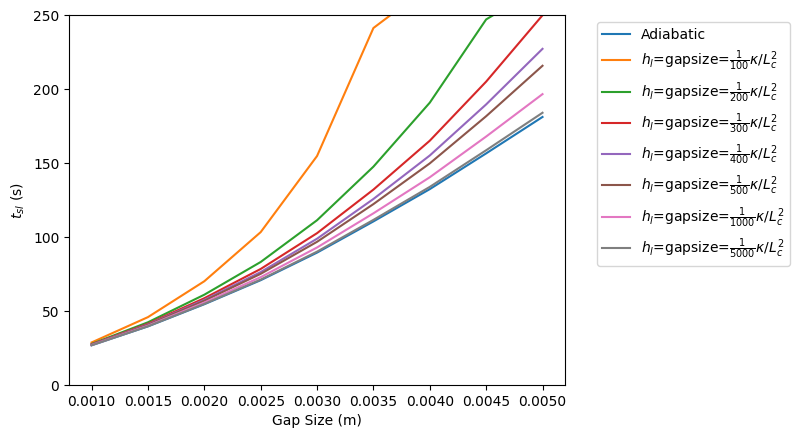

In [80]:
hs = [0, 1/100, 1/200, 1/300, 1/400, 1/500, 1/1000, 1/5000]


for h in hs:
    if h == 0:
        proc_data[0].sort()
        x,y = zip(*proc_data[0])
        plt.plot(x,y,label=f"Adiabatic")
    else:
        proc_data[int(1/h)].sort()
        x,y = zip(*proc_data[int(1/h)])
        plt.plot(x,y,label=r"$h_l$=" + r"gapsize=$\frac{{1}}{{{}}}$".format(int(1/h)) + r"$\kappa/L_c^2$")
plt.xlabel("Gap Size (m)")
plt.ylabel(r'$t_{sl}$ (s)')
plt.ylim(0,250)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')